In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Inspect first few raw lines
with open("/content/sample_data/manipal_atmospherics_df.csv", "r") as f:
    for i in range(10):
        print(f.readline())

latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation

13.321617,74.79452,97.0,19800,Asia/Kolkata,GMT+5:30



time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)

2011-01-04,24.7,0.00,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278

2011-01-05,25.4,0.00,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276

2011-01-06,26.2,0.00,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273

2011-01-07,25.6,0.00,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270

2011-01-08,25.2,0.00,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268

2011-01-09,25.2,0.00,20.82,28.4,18.3,4.49,37701.15,297,1008.0,52,20.0,0.266



In [3]:
DATA_PATH = "/content/sample_data/manipal_atmospherics_df.csv"

df = pd.read_csv(
    DATA_PATH,
    skiprows=2,              # skip metadata rows
    parse_dates=["time"]
)

df = df.sort_values("time").reset_index(drop=True)

# Rename columns
df = df.rename(columns={
    "time": "date",
    "temperature_2m_mean (°C)": "temp_mean",
    "precipitation_sum (mm)": "precip_sum",
    "shortwave_radiation_sum (MJ/m²)": "solar_radiation",
    "apparent_temperature_mean (°C)": "apparent_temp",
    "wind_speed_10m_max (km/h)": "wind_speed",
    "et0_fao_evapotranspiration (mm)": "evapotranspiration",
    "sunshine_duration (s)": "sunshine_duration",
    "wind_direction_10m_dominant (°)": "wind_direction",
    "pressure_msl_mean (hPa)": "pressure",
    "cloud_cover_mean (%)": "cloud_cover",
    "dew_point_2m_mean (°C)": "dew_point",
    "soil_moisture_0_to_7cm_mean (m³/m³)": "soil_moisture"
})

df.head()

,date,temp_mean,precip_sum,solar_radiation,apparent_temp,wind_speed,evapotranspiration,sunshine_duration,wind_direction,pressure,cloud_cover,dew_point,soil_moisture
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268


In [4]:
print(df.head())
print(df.info())
print(df.isna().sum())
print("Date range:", df["date"].min(), "→", df["date"].max())

        date  temp_mean  precip_sum  solar_radiation  apparent_temp  \
0 2011-01-04       24.7         0.0            19.69           27.7   
1 2011-01-05       25.4         0.0            17.77           28.5   
2 2011-01-06       26.2         0.0            19.31           28.8   
3 2011-01-07       25.6         0.0            20.26           28.0   
4 2011-01-08       25.2         0.0            20.29           28.2   

   wind_speed  evapotranspiration  sunshine_duration  wind_direction  \
0        17.4                4.09           36798.94             325   
1        15.9                3.91           36494.80             309   
2        18.4                4.45           36924.74             319   
3        15.6                4.52           37417.72             178   
4        15.1                4.38           37473.21             313   

   pressure  cloud_cover  dew_point  soil_moisture  
0    1009.7           70       20.4          0.278  
1    1008.7           85       20.

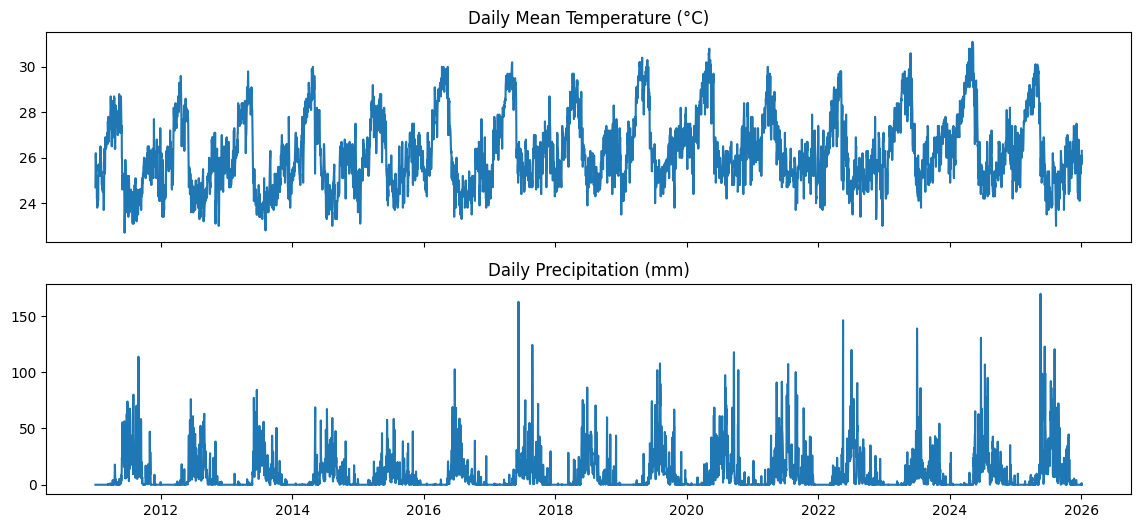

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(df["date"], df["temp_mean"])
ax[0].set_title("Daily Mean Temperature (°C)")

ax[1].plot(df["date"], df["precip_sum"])
ax[1].set_title("Daily Precipitation (mm)")

plt.show()

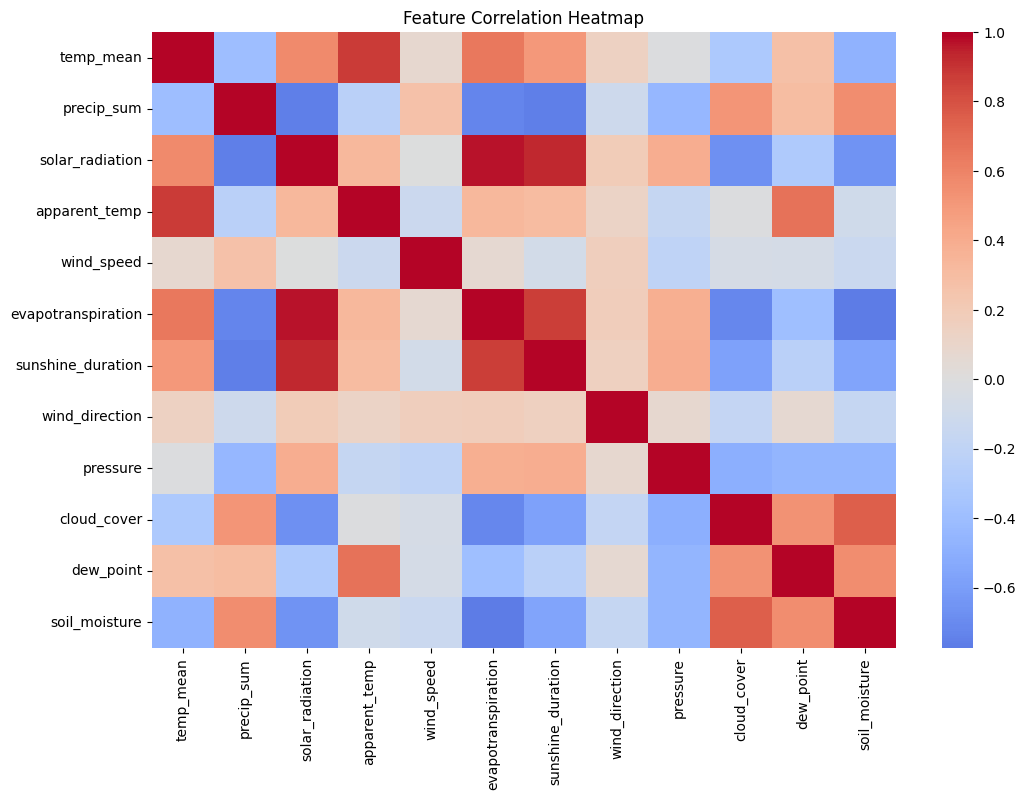

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df.drop(columns=["date"]).corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Feature Correlation Heatmap")
plt.show()

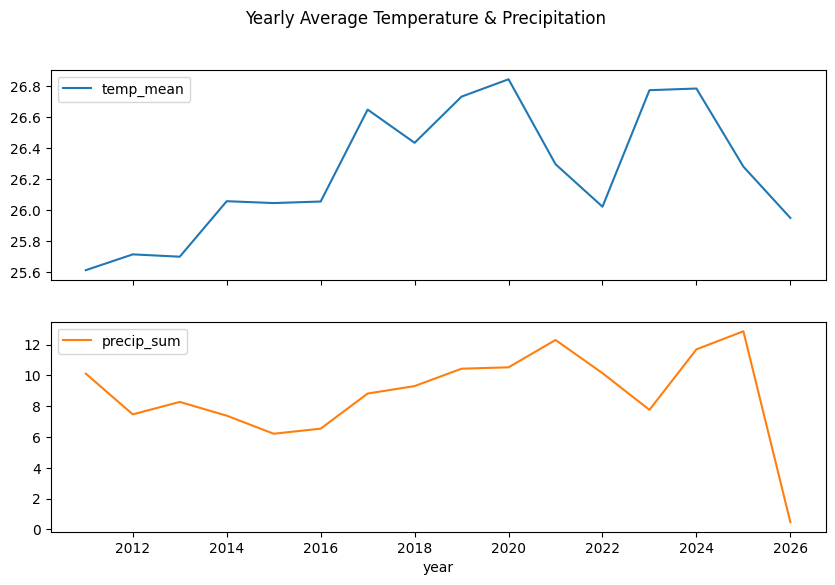

In [7]:
df["year"] = df["date"].dt.year

yearly = df.groupby("year")[["temp_mean", "precip_sum"]].mean()

yearly.plot(
    subplots=True,
    figsize=(10, 6),
    title="Yearly Average Temperature & Precipitation"
)
plt.show()

In [8]:
df["day_of_year"] = df["date"].dt.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

In [9]:
FEATURES = [
    "temp_mean",
    "precip_sum",
    "solar_radiation",
    "apparent_temp",
    "wind_speed",
    "evapotranspiration",
    "sunshine_duration",
    "wind_direction",
    "pressure",
    "cloud_cover",
    "dew_point",
    "soil_moisture",
    "sin_doy",
    "cos_doy"
]

TARGETS = ["temp_mean", "precip_sum"]

In [10]:
train_df = df[df["date"] <= "2023-12-31"]
val_df   = df[(df["date"] > "2023-12-31") & (df["date"] <= "2024-12-31")]
test_df  = df[df["date"] > "2024-12-31"]

print(len(train_df), len(val_df), len(test_df))

4745 366 369


In [11]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df[FEATURES])
val_scaled   = scaler.transform(val_df[FEATURES])
test_scaled  = scaler.transform(test_df[FEATURES])

In [12]:
class WeatherDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __len__(self):
        return len(self.data) - self.window

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.window]
        y = self.data[idx+self.window][:2]  # temp + precip
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [13]:
WINDOW = 30
BATCH_SIZE = 64

train_ds = WeatherDataset(train_scaled, WINDOW)
val_ds   = WeatherDataset(val_scaled, WINDOW)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

In [15]:
def train_model(model, train_loader, val_loader, epochs=25):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X, y in train_loader:
            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                val_loss += loss_fn(model(X), y).item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1:02d} | Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [16]:
model = LSTMForecaster(input_dim=len(FEATURES))
train_losses, val_losses = train_model(model, train_loader, val_loader)

Epoch 01 | Train 0.4848 | Val 0.4599
Epoch 02 | Train 0.3432 | Val 0.3964
Epoch 03 | Train 0.2933 | Val 0.3653
Epoch 04 | Train 0.2728 | Val 0.3555
Epoch 05 | Train 0.2602 | Val 0.3450
Epoch 06 | Train 0.2496 | Val 0.3389
Epoch 07 | Train 0.2418 | Val 0.3356
Epoch 08 | Train 0.2372 | Val 0.3318
Epoch 09 | Train 0.2338 | Val 0.3329
Epoch 10 | Train 0.2305 | Val 0.3317
Epoch 11 | Train 0.2269 | Val 0.3347
Epoch 12 | Train 0.2230 | Val 0.3517
Epoch 13 | Train 0.2180 | Val 0.3751
Epoch 14 | Train 0.2114 | Val 0.3740
Epoch 15 | Train 0.2085 | Val 0.3484
Epoch 16 | Train 0.2058 | Val 0.3616
Epoch 17 | Train 0.2016 | Val 0.4014
Epoch 18 | Train 0.1955 | Val 0.4278
Epoch 19 | Train 0.1883 | Val 0.3925
Epoch 20 | Train 0.1940 | Val 0.4285
Epoch 21 | Train 0.1835 | Val 0.4464
Epoch 22 | Train 0.1701 | Val 0.5180
Epoch 23 | Train 0.1666 | Val 0.4451
Epoch 24 | Train 0.1775 | Val 0.4396
Epoch 25 | Train 0.1637 | Val 0.4740


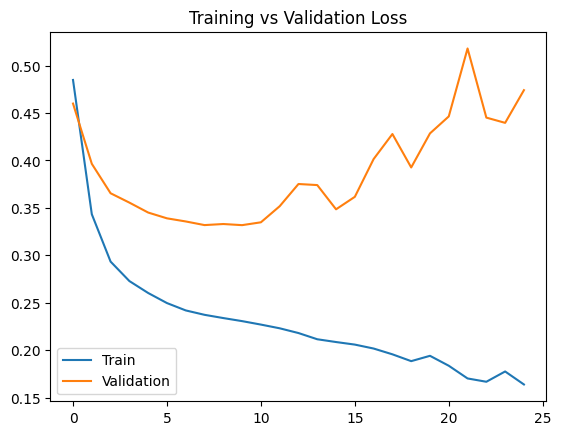

In [17]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [18]:
model.eval()
predictions = []

for i in range(len(test_scaled) - WINDOW):
    window = torch.tensor(
        test_scaled[i:i+WINDOW],
        dtype=torch.float32
    ).unsqueeze(0)

    with torch.no_grad():
        pred = model(window).cpu().numpy()[0]

    predictions.append(pred)

predictions = np.array(predictions)
# Sanity check, it was breaking as preserves the dtype → torch.float64
print(window.dtype)
for p in model.parameters():
    print(p.dtype)
    break

torch.float32
torch.float32


In [19]:
true_rows, pred_rows = [], []

for i in range(len(predictions)):
    base = test_scaled[i+WINDOW].copy()

    pred_row = base.copy()
    pred_row[:2] = predictions[i]

    true_rows.append(base)
    pred_rows.append(pred_row)

true_inv = scaler.inverse_transform(true_rows)[:, :2]
pred_inv = scaler.inverse_transform(pred_rows)[:, :2]

In [20]:
print("MAE:", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))

MAE: 3.904397573216127
RMSE: 11.380919695154212


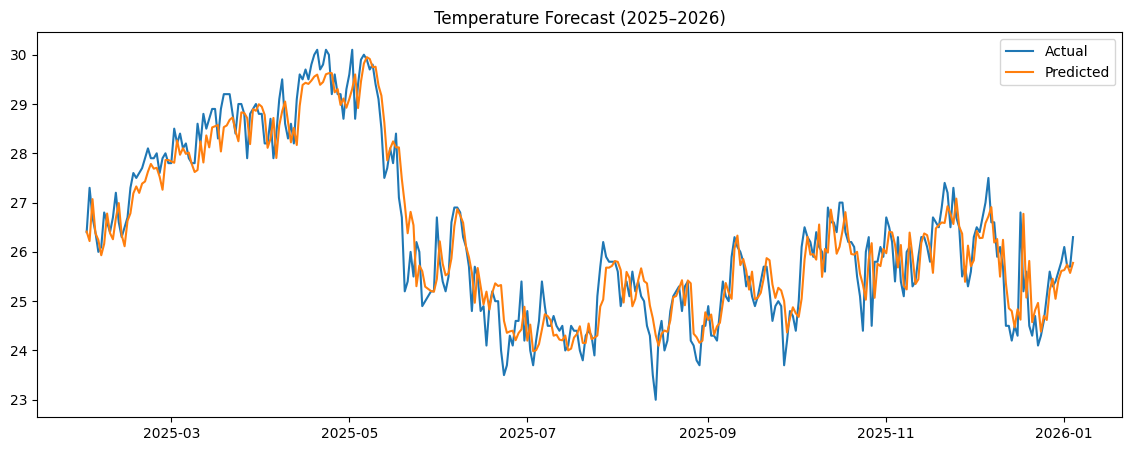

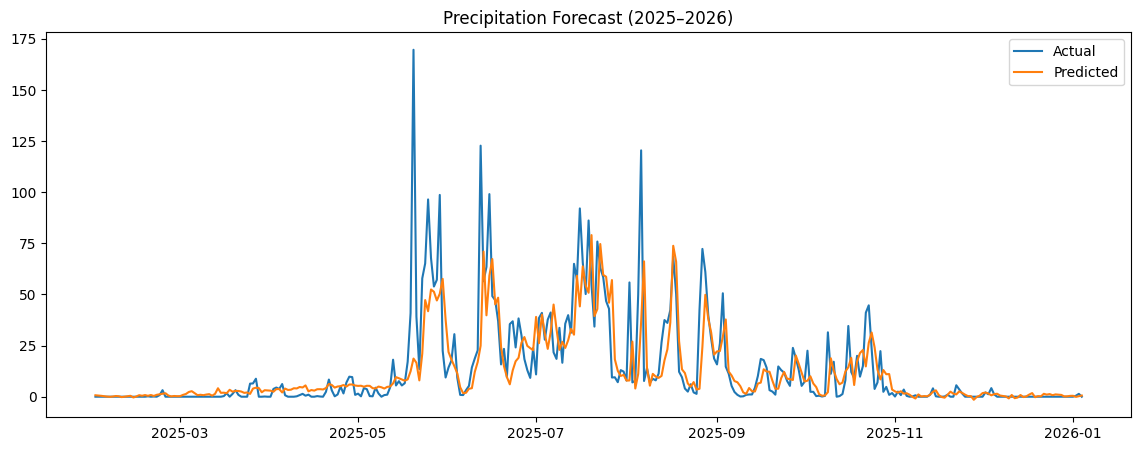

In [21]:
dates = test_df["date"].iloc[WINDOW:]

plt.figure(figsize=(14,5))
plt.plot(dates, true_inv[:,0], label="Actual")
plt.plot(dates, pred_inv[:,0], label="Predicted")
plt.title("Temperature Forecast (2025–2026)")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(dates, true_inv[:,1], label="Actual")
plt.plot(dates, pred_inv[:,1], label="Predicted")
plt.title("Precipitation Forecast (2025–2026)")
plt.legend()
plt.show()

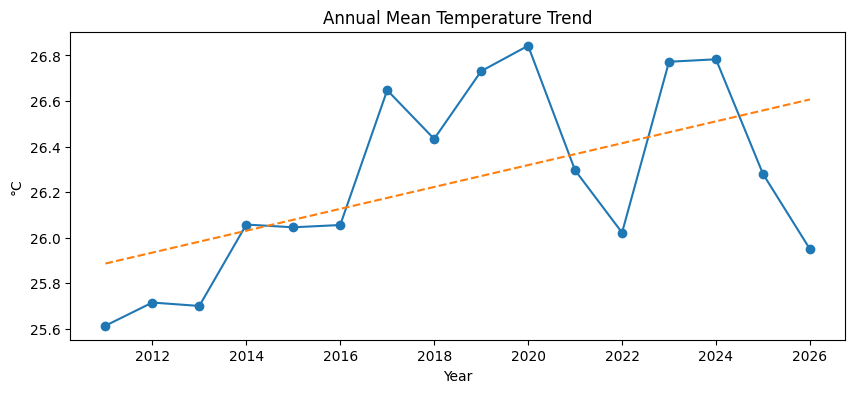

Temperature increase: 0.0480 °C / year


In [22]:
annual = df.groupby(df["date"].dt.year)["temp_mean"].mean().reset_index()
annual.columns = ["year", "temp"]

lr = LinearRegression().fit(annual[["year"]], annual["temp"])

plt.figure(figsize=(10,4))
plt.plot(annual["year"], annual["temp"], marker="o")
plt.plot(annual["year"], lr.predict(annual[["year"]]), linestyle="--")
plt.title("Annual Mean Temperature Trend")
plt.xlabel("Year")
plt.ylabel("°C")
plt.show()

print(f"Temperature increase: {lr.coef_[0]:.4f} °C / year")